# Chatbot with Memory Profile

## Review

We extended our chatbot by saving memories using a [structured schema](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition).

And we updated memories [as a collection](https://langchain-ai.github.io/langgraph/concepts/memory/#manage-a-collection-of-memories), simply adding to the existing collection as we learn more about the user. 

## Goals

There are cases where we don't want to update a collection of memories. 

Rather we want to continually update a single document, such [as a single user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#manage-individual-profiles).

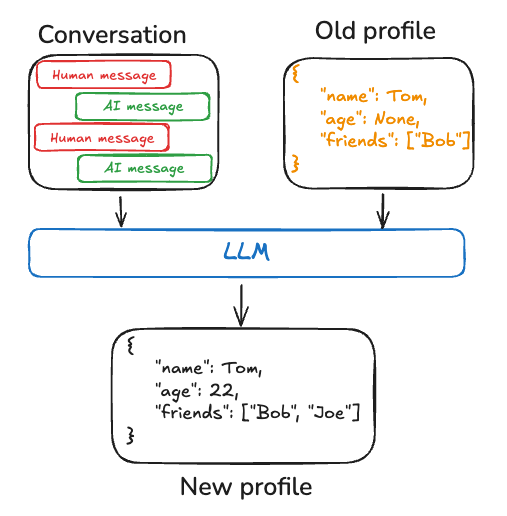

Or, we want the ability to update existing memories. We'll introduce that functionality with this chatbot.

In [2]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [3]:
os.environ["LANGCHAIN_API_KEY"] = "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"

## Profile Schema

Let's use [Pydantic](https://docs.pydantic.dev/latest/) to define a schema for a single user profile.

In [5]:
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Schema
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    interests: list = Field(description="A list of the user's interests")

# Bind UserProfile schema as a tool to the model
model_with_tools = model.bind_tools([UserProfile])

# Invoke the model
output = model_with_tools.invoke([HumanMessage("Hi!.")])
output.pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


## Managing a single profile with our chatbot

Now, we can bring this all together and improve our chatbot in two ways: 

First, it will decide when to save memories.

Second, it will extract the structured information from the message(s) into the specified memory schema.

Third, it will save the memories as a single profile, updating the existing profile as we learn more about the user.

This follows example what we did before, but now we simply overwrite the existing profile using a common key, `key = "user_profile"`.

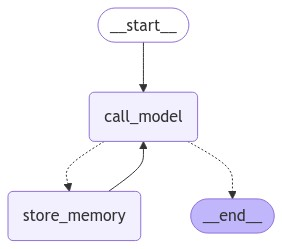

In [14]:
from IPython.display import Image, display

import uuid
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Call the model with the system prompt that contains the memories as well as the user's messages."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"[{mem.key}]: {mem.value}" for mem in memories)
    system_msg = f"""You are a helpful assistant talking to the user. 
    Update the user profile as you learn more. 
    Here is existing user profile: {info}"""

    # Invoke the model with the system prompt that contains the memories as well as the user's messages
    response = model_with_tools.invoke([SystemMessage(content=system_msg)]+state["messages"])
    return {"messages": response}

def store_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Store the tool calls in the memory store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Generate a common key for the profile, overwriting any existing profile
    key = "user_profile"

    # Extract tool calls from the last message
    tool_calls = state['messages'][-1].tool_calls

    # Save each produced tool call schema to the store
    for tc in tool_calls:
        in_memory_store.put(namespace, key, tc["args"])

    # Create tool messages to confirm to the model that the tool calls were successful
    results = [
        ToolMessage(content=tc["args"], tool_call_id=tc["id"])
        for tc in tool_calls
    ]
    return {"messages": results}

def route_message(state: MessagesState):
    
    """Determine the next step based on the presence of tool calls."""

    # Get the last message from the user
    msg = state['messages'][-1]

    # If there are tool calls, we need to store memories
    if msg.tool_calls:
        return "store_memory"
    
    # Otherwise, finish; user can send the next message
    return END

# Define the graph
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(call_model)
builder.add_edge(START, "call_model")
builder.add_node(store_memory)
builder.add_conditional_edges("call_model", route_message, ["store_memory", END])
builder.add_edge("store_memory", "call_model")

# Store from cross-thread memory
in_memory_store = InMemoryStore()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=MemorySaver(), store=in_memory_store)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [15]:
# We supply a user ID for across-thread memory as well as a thread ID for within-thread memory
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="Hi! My name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! My name is Lance
================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_4Zr4g8Ozs72aPVuXvsNoIv1H)
 Call ID: call_4Zr4g8Ozs72aPVuXvsNoIv1H
  Args:
    user_name: Lance
    interests: []
================================= Tool Message =================================

{'user_name': 'Lance', 'interests': []}
================================== Ai Message ==================================

Hi Lance! How can I assist you today?


In [16]:
# Chat with the chatbot
input_messages = [HumanMessage(content="I like to bike around San Francisco.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco.
================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_QlHn7pNKAmpHF1NRNHS04umv)
 Call ID: call_QlHn7pNKAmpHF1NRNHS04umv
  Args:
    user_name: Lance
    interests: ['biking', 'San Francisco']
================================= Tool Message =================================

{'user_name': 'Lance', 'interests': ['biking', 'San Francisco']}
================================== Ai Message ==================================

That's great, Lance! Biking around San Francisco sounds like a lot of fun. Do you have any favorite routes or spots in the city?


In [17]:
# Chat with the chatbot
input_messages = [HumanMessage(content="I also like to go to bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also like to go to bakeries.
================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_ZiKwQ9nZliiNJGOqRBRKk6gx)
 Call ID: call_ZiKwQ9nZliiNJGOqRBRKk6gx
  Args:
    user_name: Lance
    interests: ['biking', 'San Francisco', 'bakeries']
================================= Tool Message =================================

{'user_name': 'Lance', 'interests': ['biking', 'San Francisco', 'bakeries']}
================================== Ai Message ==================================

Biking to different bakeries in San Francisco sounds like a delicious adventure! Do you have a favorite bakery or a type of pastry you enjoy the most?


We can see that we're successfully updating the user profile as we learn more about the user!

We just overwrite the profile with a new one, because we used a common key, `key = "user_profile"`.

In [18]:
# Namespace for the memory to save
user_id = "Lance"
namespace = ("memories", user_id)

# Search 
for memory in in_memory_store.search(namespace):
    print(memory.dict())

{'value': {'user_name': 'Lance', 'interests': ['biking', 'San Francisco', 'bakeries']}, 'key': 'user_profile', 'namespace': ['memories', 'Lance'], 'created_at': '2024-10-23T23:40:29.323770+00:00', 'updated_at': '2024-10-23T23:40:34.795971+00:00'}


## LangSmith 

https://smith.langchain.com/public/04c76a72-225f-4904-8bf2-463a7e985ffb/r